# Agent environment with bitflipping actions

## Neural network model details
 * Input: $\mathbb{R}^n$ vector representing the bit sequence (e.g. $00011 \sim (0, 0, 0, 1, 1)$)
 * Output: $\mathbb{R}^{n}$ vector of the $Q$-values
    * The index corresponds to integer $\geq 0$ representing the index of the bit being flipped
    * So $\text{model}(s)[a]$ will be the $Q$-value
 * Architecture: Simple MLP

## Training method
Simple DQN with replay
   * Exploration step -> update Q network -> validation step

**Exploration step**
We initialize 16 agents starting at random starting states (for each agent). The actions will be according to the DQN agent, and with probability $\epsilon$, a random action will be picked uniformly. We add this to the experience buffer.

**Update Q network**
Update the DQN to match Bellman's equation using a randomly sampled batch size ($=128$), and this is done with gradient descent.

**Validation step**
Access the performance of the learnt policy. Initialize 1024 random starting states, and let the agent fully decide the actions (we do not replace actions with probability $\epsilon$ with uniform distribution). Since this is the validation step, this should not interfere with the training process, and the experience buffer won't be updated.


## Notes
For an optimal agent, $E[\text{steps}] = \frac{1}{2^n}\sum_{k=0}^n \dbinom{n}{k}k = \frac{n}{2}$. We expect the average number of steps to be close to $\frac{n}{2}$ if an optimal agent is chosen.

In [1]:
from src.environments.env_bit_sequence_flipping import FlippingBitSequenceEnv
from src.agents.agent_dqn import DQNAgent
from src.models.model_dqn_bitflipping import BitFlippingDQNNetwork
from src.models.buffer_bitflipping import BufferBitflipping

import numpy as np
import torch

from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

device = torch.device("cuda:0")

def train_DQN_agent(n: int, device: torch.device,
    episodes: int=1000, num_explore_agents: int=16, num_valid_agents: int=1024,
    batch_size: int=2048) -> None:

    # initialize environment, model and agent
    env = FlippingBitSequenceEnv(n, device, fix_original_state=False)
    model = BitFlippingDQNNetwork(n)
    model.to(device)
    running_model = BitFlippingDQNNetwork(n)
    running_model.to(device)
    buffer = BufferBitflipping(n, device=device, no_repeat=False, max_buffer_size=2 ** 13)
    agent = DQNAgent(model=model, running_model=running_model,
                     buffer=buffer, device=device,
                     action_space_size=n)
    
    target_value = n / 2 if not env.fix_original_state else env.get_initial_distance()

    success_rates = []
    steps_to_success = []
    loss_values = []
    mean_distances = []
    for e in tqdm(range(episodes)):
        # initial state is numpy array, convert to torch tensor
        state = env.reset(num_agents=num_explore_agents)

        # let agent act for at most 2n steps
        for _ in range(2 * n):  # max time steps
            with torch.no_grad():
                action = agent.act(state)
                next_state, reward, done, info = env.step(action)
                prev_done = info["previous_done"] # tensor indicating if the prior state was already terminal
                prev_step_ongoing = ~prev_done
                agent.remember(state[prev_step_ongoing, :].cpu().numpy(), action[prev_step_ongoing].cpu().numpy(),
                               reward[prev_step_ongoing].cpu().numpy(), next_state[prev_step_ongoing, :].cpu().numpy(), done[prev_step_ongoing].cpu().numpy())
                state = next_state
                if done.all():
                    break
        
            # replay to update Q network
            loss = agent.replay(batch_size=batch_size, opt_steps=1)
        with torch.no_grad():
            mean_distance = env.distance_to_target(state).to(torch.float32).mean().item()

        # now run the agent for at most 2n steps to see if it has learned (without random exploration, and without affecting the replay buffer)
        # we use random initial states
        state = env.reset(num_agents=num_valid_agents)
        agent_steps_to_success = np.ones(num_valid_agents)
        for step in range(2 * n):  # max time steps
            with torch.no_grad():
                action = agent.act(state, explore=False)
                next_state, reward, done, info = env.step(action)
                prev_done = info["previous_done"] # tensor indicating if the prior state was already terminal
                prev_step_ongoing = ~prev_done
                state = next_state

                if step == 0: # if by random chance the agent is already done in the first step, we need to handle this case
                    agent_steps_to_success[prev_done.cpu().numpy()] = 0
                agent_steps_to_success[~done.cpu().numpy()] += 1
                if done.all():
                    break
        success_rate = ((done.sum().item() + 0.0) / num_valid_agents)
        avg_steps_to_success = agent_steps_to_success.mean()
        success_rates.append(success_rate)
        steps_to_success.append(avg_steps_to_success)
        loss_values.append(loss)
        mean_distances.append(mean_distance)

        if e > 100 and (np.array(steps_to_success[-100:]) < target_value + 1).all():
            print("Early stopping at episode", e)
            print("Episode: {}/{}, Epsilon: {}, Success rate: {:.2f}, Avg steps to success: {:.2f}, Loss: {:.6f}".format(e, episodes, agent.epsilon, success_rate, avg_steps_to_success, loss))
            break

        if (e + 1) % 100 == 0:
            print("Episode: {}/{}, Epsilon: {}, Success rate: {:.2f}, Avg steps to success: {:.2f}, Loss: {:.6f}".format(e, episodes, agent.epsilon, success_rate, avg_steps_to_success, loss))
    
    # plot success rates and steps to success over episodes
    plt.figure(figsize=(24, 16))
    plt.subplot(2, 3, 1)
    plt.plot(success_rates)
    plt.xlabel("Episodes")
    plt.ylabel("Success rate")
    plt.title("Success rate over episodes")
    plt.subplot(2, 3, 2)
    plt.plot(steps_to_success)
    plt.xlabel("Episodes")
    plt.ylabel("Steps to success")
    plt.title("Steps to success over episodes")
    plt.subplot(2, 3, 3)
    plt.plot(steps_to_success)
    plt.ylim(target_value - 1, target_value + 1)
    plt.xlabel("Episodes")
    plt.ylabel("Steps to success")
    plt.title("Steps to success over episodes (Zoom)")
    plt.subplot(2, 3, 4)
    plt.plot(loss_values)
    plt.xlabel("Episodes")
    plt.ylabel("Loss")
    plt.title("Loss over episodes")
    plt.subplot(2, 3, 5)
    plt.plot(mean_distances)
    plt.xlabel("Mean distance to target")
    plt.ylabel("Loss")
    plt.title("Mean distance to target over episodes")
    plt.show()

    print(buffer.buffer_size)
    return model, running_model

# Experiments

$n=2$, optimal agent achieved as steps $\sim 1$

Initialized FlippingBitSequenceEnv with n = 2. Randomly picked target: tensor([1, 1], device='cuda:0')
Initial distance to target: 2
-------------------- Initializing DQNAgent --------------------
gamma: 0.95
epsilon: 1.0
epsilon_min: 0.05
epsilon_decay: 0.999
learning_rate: 0.001


 10%|█         | 101/1000 [00:02<00:22, 40.79it/s]


Episode: 99/1000, Epsilon: 0.6789596158607596, Success rate: 1.00, Avg steps to success: 1.00, Loss: 0.000001
Early stopping at episode 101
Episode: 101/1000, Epsilon: 0.6742211329618302, Success rate: 1.00, Avg steps to success: 1.04, Loss: 0.000001


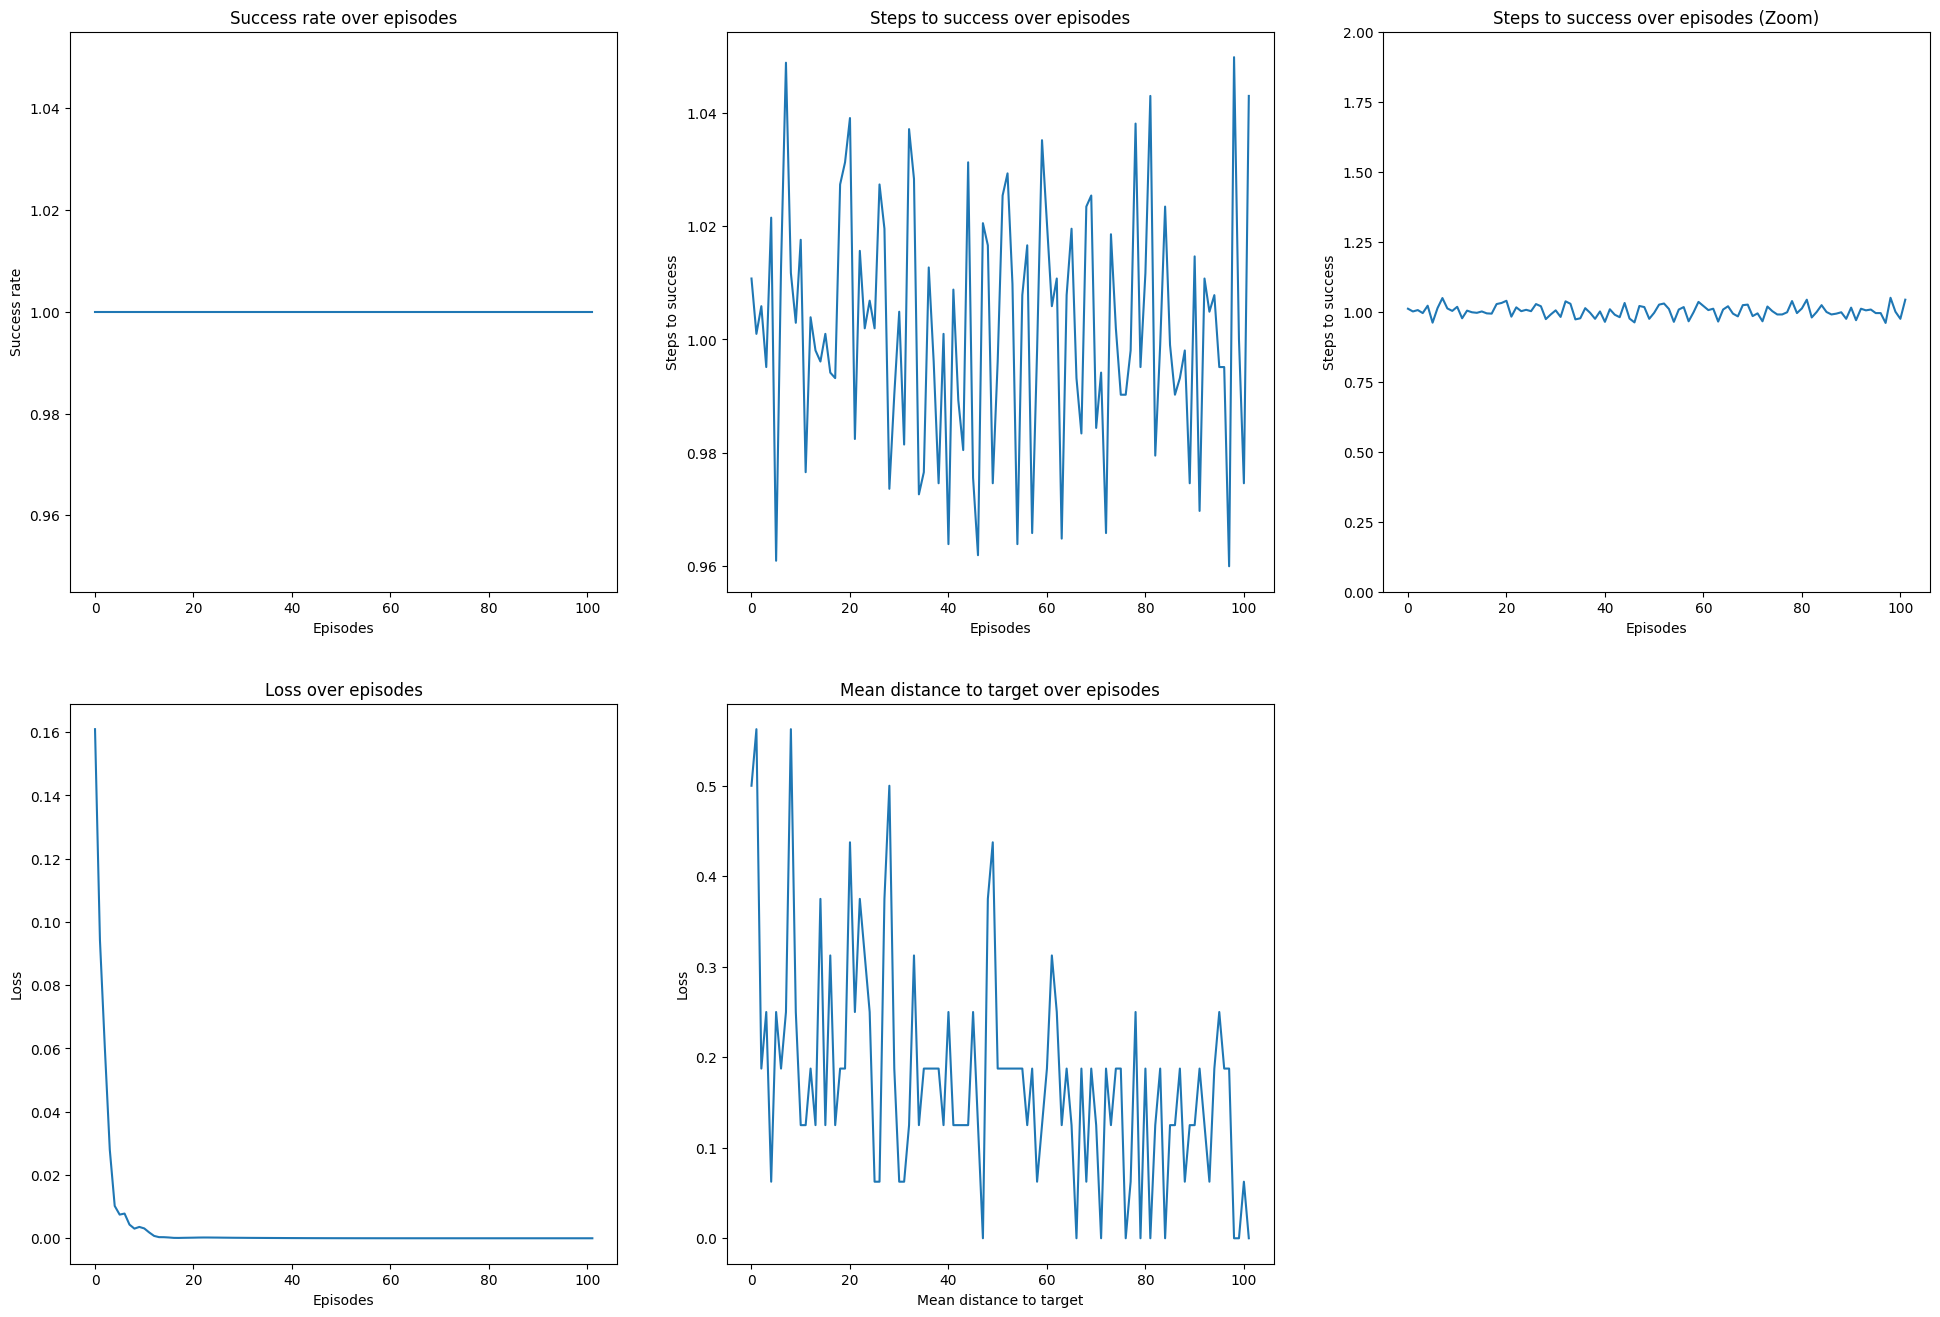

2795


(BitFlippingDQNNetwork(
   (fc1): Linear(in_features=2, out_features=128, bias=True)
   (fc2): Linear(in_features=128, out_features=128, bias=True)
   (fc3): Linear(in_features=128, out_features=2, bias=True)
 ),
 BitFlippingDQNNetwork(
   (fc1): Linear(in_features=2, out_features=128, bias=True)
   (fc2): Linear(in_features=128, out_features=128, bias=True)
   (fc3): Linear(in_features=128, out_features=2, bias=True)
 ))

In [2]:
train_DQN_agent(2, device=device)

$n=3$, optimal agent achieved as steps $\sim \frac{3}{2}$

Initialized FlippingBitSequenceEnv with n = 3. Randomly picked target: tensor([1, 1, 1], device='cuda:0')
Initial distance to target: 3
-------------------- Initializing DQNAgent --------------------
gamma: 0.95
epsilon: 1.0
epsilon_min: 0.05
epsilon_decay: 0.999
learning_rate: 0.001


 10%|█         | 101/1000 [00:02<00:26, 33.74it/s]


Episode: 99/1000, Epsilon: 0.5536095095627305, Success rate: 1.00, Avg steps to success: 1.51, Loss: 0.000075
Early stopping at episode 101
Episode: 101/1000, Epsilon: 0.5470026121551156, Success rate: 1.00, Avg steps to success: 1.46, Loss: 0.000067


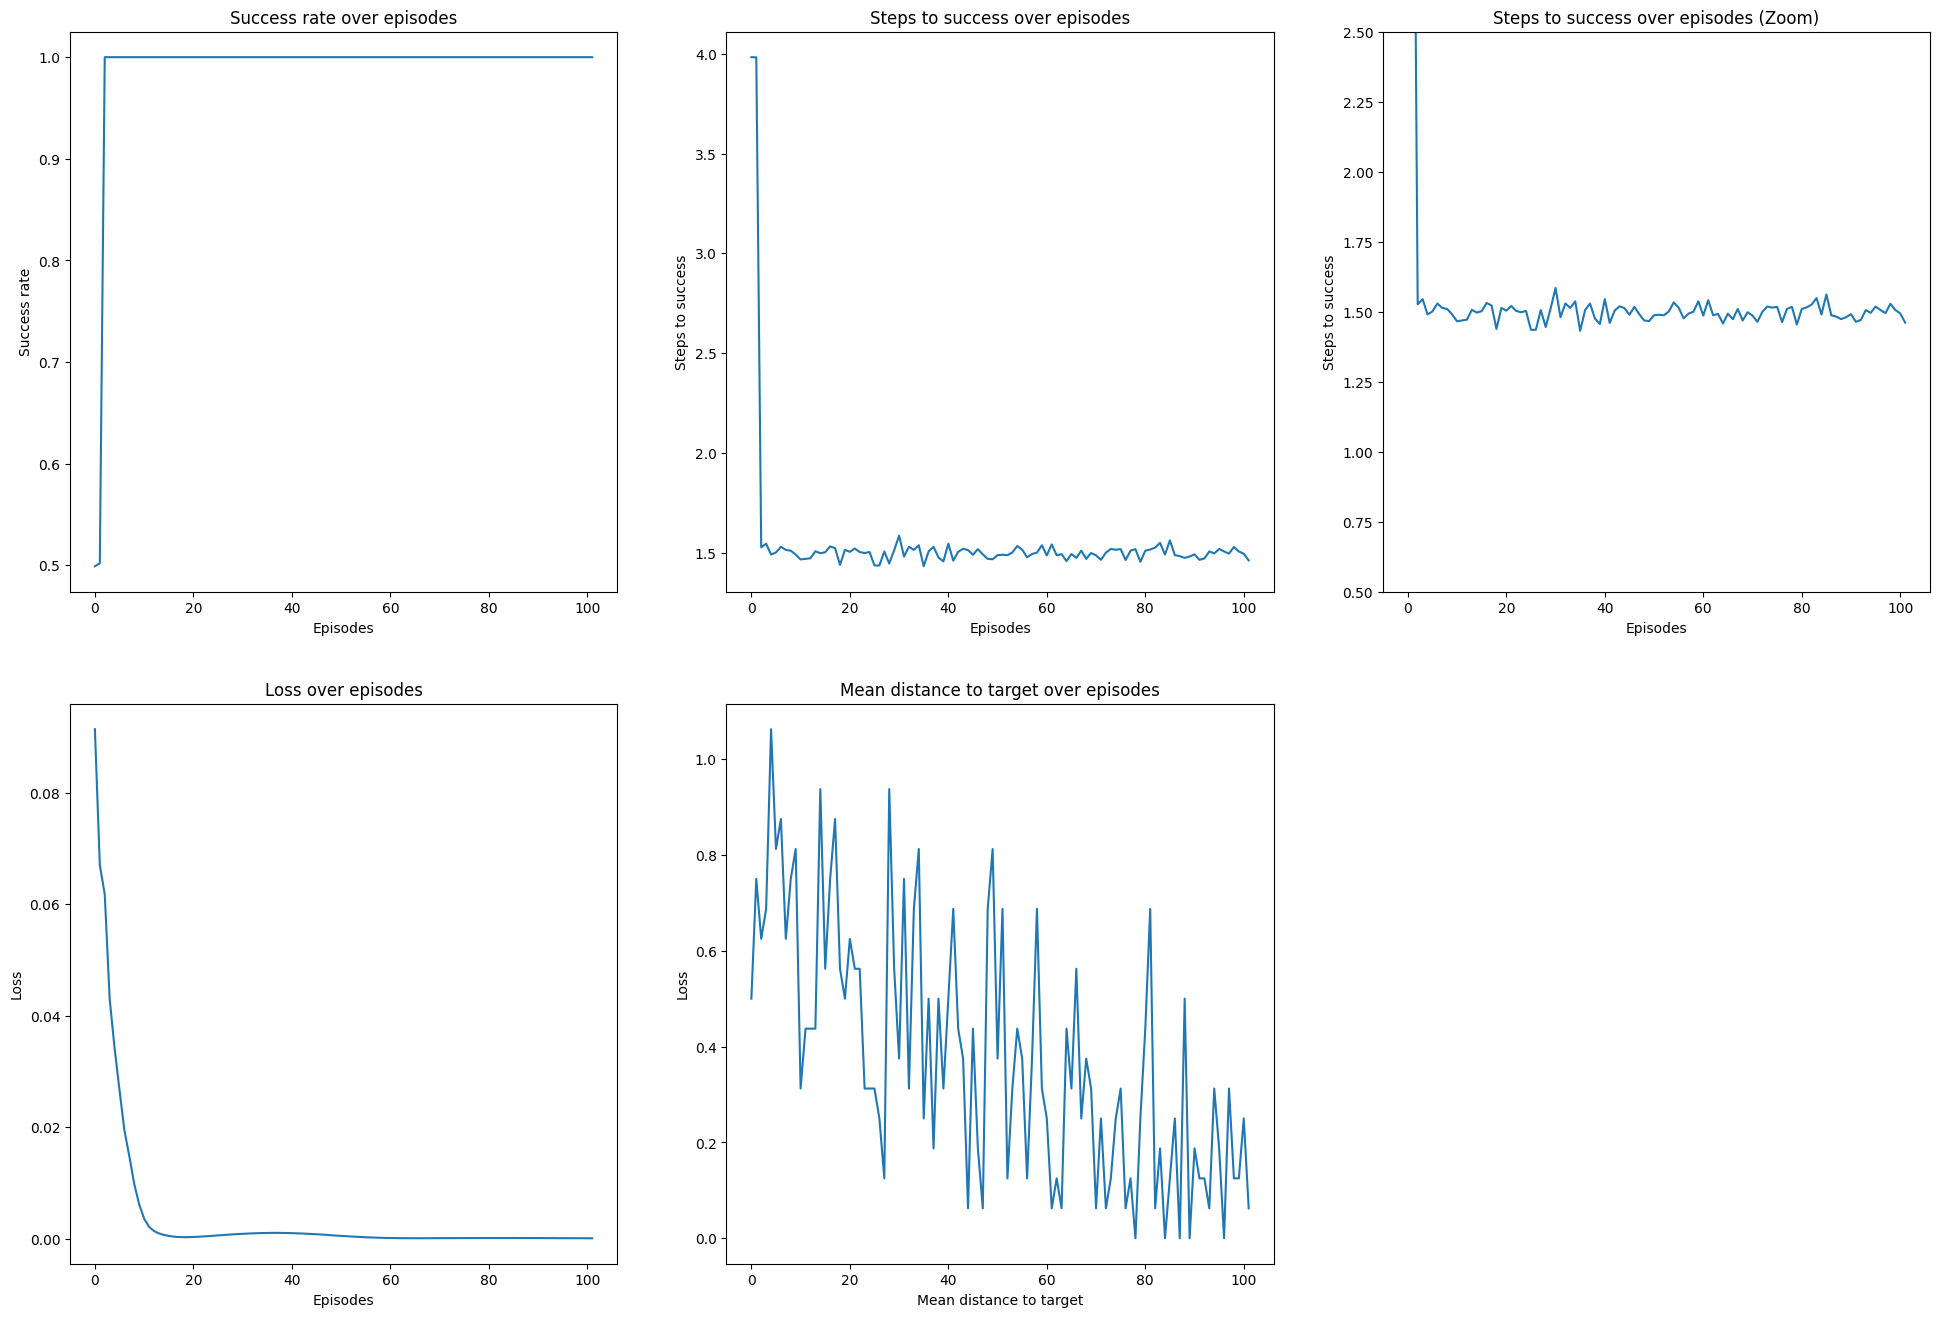

5196


(BitFlippingDQNNetwork(
   (fc1): Linear(in_features=3, out_features=128, bias=True)
   (fc2): Linear(in_features=128, out_features=128, bias=True)
   (fc3): Linear(in_features=128, out_features=3, bias=True)
 ),
 BitFlippingDQNNetwork(
   (fc1): Linear(in_features=3, out_features=128, bias=True)
   (fc2): Linear(in_features=128, out_features=128, bias=True)
   (fc3): Linear(in_features=128, out_features=3, bias=True)
 ))

In [3]:
train_DQN_agent(3, device=device)

$n=6$, optimal agent achieved as steps $\sim 3$

Initialized FlippingBitSequenceEnv with n = 6. Randomly picked target: tensor([0, 1, 0, 0, 1, 0], device='cuda:0')
Initial distance to target: 5
-------------------- Initializing DQNAgent --------------------
gamma: 0.95
epsilon: 1.0
epsilon_min: 0.05
epsilon_decay: 0.999
learning_rate: 0.001


 10%|█         | 104/1000 [00:04<00:25, 34.84it/s]

Episode: 99/1000, Epsilon: 0.31236531710902116, Success rate: 1.00, Avg steps to success: 2.99, Loss: 0.000002


 20%|██        | 204/1000 [00:07<00:28, 27.59it/s]

Episode: 199/1000, Epsilon: 0.11741140683121218, Success rate: 0.29, Avg steps to success: 9.88, Loss: 0.000002


 31%|███       | 308/1000 [00:10<00:16, 41.65it/s]

Episode: 299/1000, Epsilon: 0.05, Success rate: 1.00, Avg steps to success: 3.18, Loss: 0.000000


 41%|████      | 408/1000 [00:13<00:12, 49.19it/s]

Episode: 399/1000, Epsilon: 0.05, Success rate: 1.00, Avg steps to success: 3.20, Loss: 0.000002


 49%|████▉     | 491/1000 [00:14<00:15, 33.09it/s]


Early stopping at episode 491
Episode: 491/1000, Epsilon: 0.05, Success rate: 1.00, Avg steps to success: 3.19, Loss: 0.000000


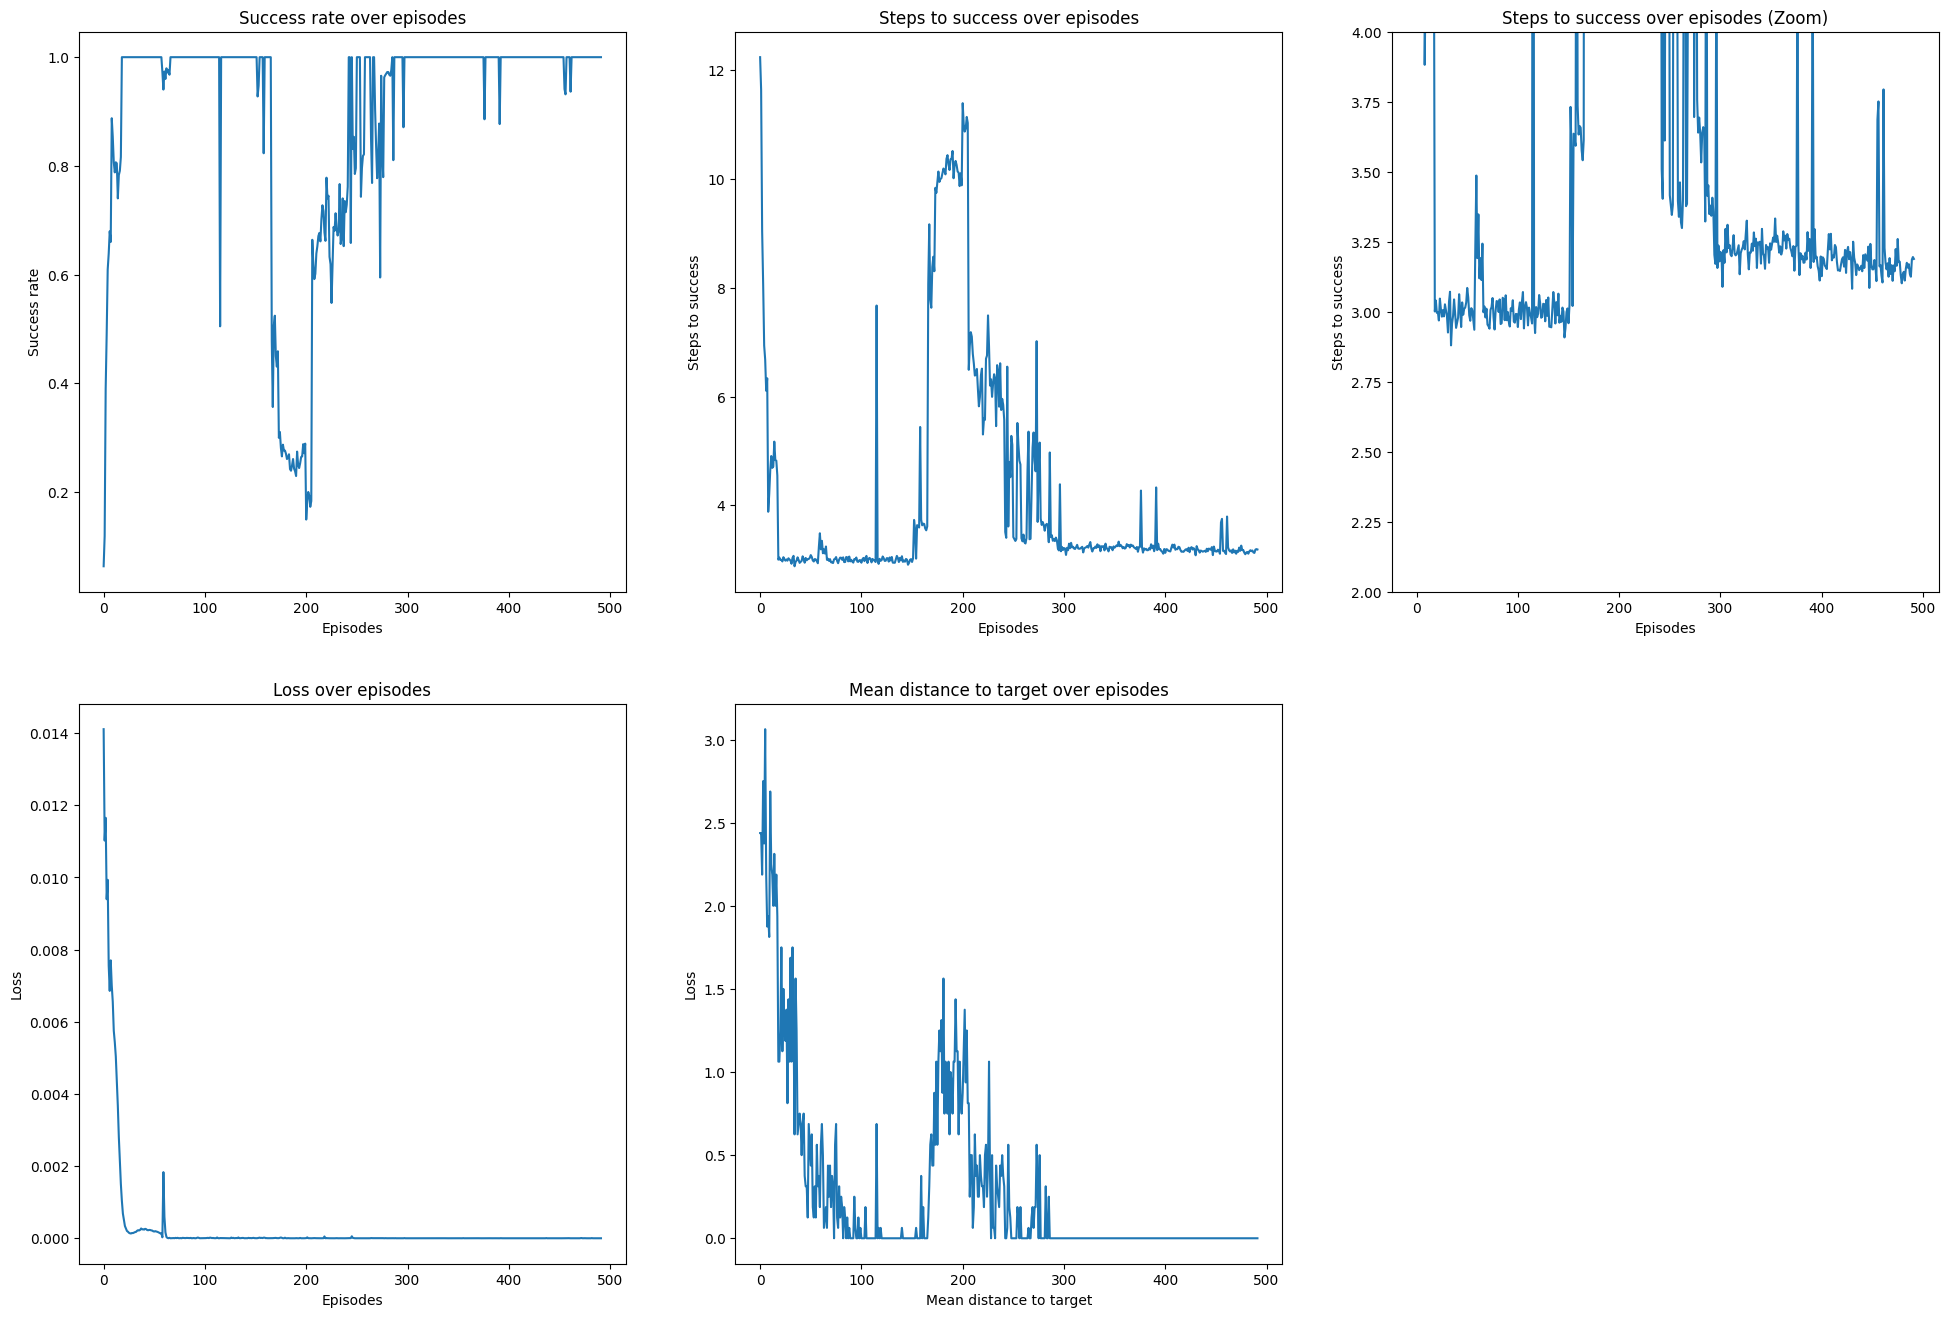

8192


In [4]:
model, running_model = train_DQN_agent(6, device=device)

In [5]:
with torch.no_grad():
    print(running_model(torch.tensor([[1, 0, 0, 1, 0, 0]]).to(device=device, dtype=torch.float32)))

tensor([[0.8239, 0.7235, 0.5843, 0.8045, 0.8113, 0.5471]], device='cuda:0')


$n=10$, optimal agent achieved as steps $\sim 5$

Initialized FlippingBitSequenceEnv with n = 10. Randomly picked target: tensor([0, 1, 1, 0, 0, 0, 1, 1, 1, 1], device='cuda:0')
Initial distance to target: 5
-------------------- Initializing DQNAgent --------------------
gamma: 0.95
epsilon: 1.0
epsilon_min: 0.05
epsilon_decay: 0.999
learning_rate: 0.001


  0%|          | 0/1000 [00:00<?, ?it/s]

 10%|█         | 104/1000 [00:06<00:38, 23.13it/s]

Episode: 99/1000, Epsilon: 0.16781508419242955, Success rate: 0.99, Avg steps to success: 5.23, Loss: 0.000006


 20%|██        | 205/1000 [00:10<00:29, 27.14it/s]

Episode: 199/1000, Epsilon: 0.05, Success rate: 0.81, Avg steps to success: 7.86, Loss: 0.000001


 30%|███       | 303/1000 [00:13<00:26, 26.79it/s]

Episode: 299/1000, Epsilon: 0.05, Success rate: 0.91, Avg steps to success: 6.26, Loss: 0.000001


 41%|████      | 406/1000 [00:16<00:17, 33.13it/s]

Episode: 399/1000, Epsilon: 0.05, Success rate: 1.00, Avg steps to success: 5.01, Loss: 0.000000


 50%|█████     | 504/1000 [00:19<00:15, 32.32it/s]

Episode: 499/1000, Epsilon: 0.05, Success rate: 1.00, Avg steps to success: 5.09, Loss: 0.000000


 51%|█████     | 510/1000 [00:20<00:19, 25.49it/s]


Early stopping at episode 510
Episode: 510/1000, Epsilon: 0.05, Success rate: 0.99, Avg steps to success: 5.17, Loss: 0.000003


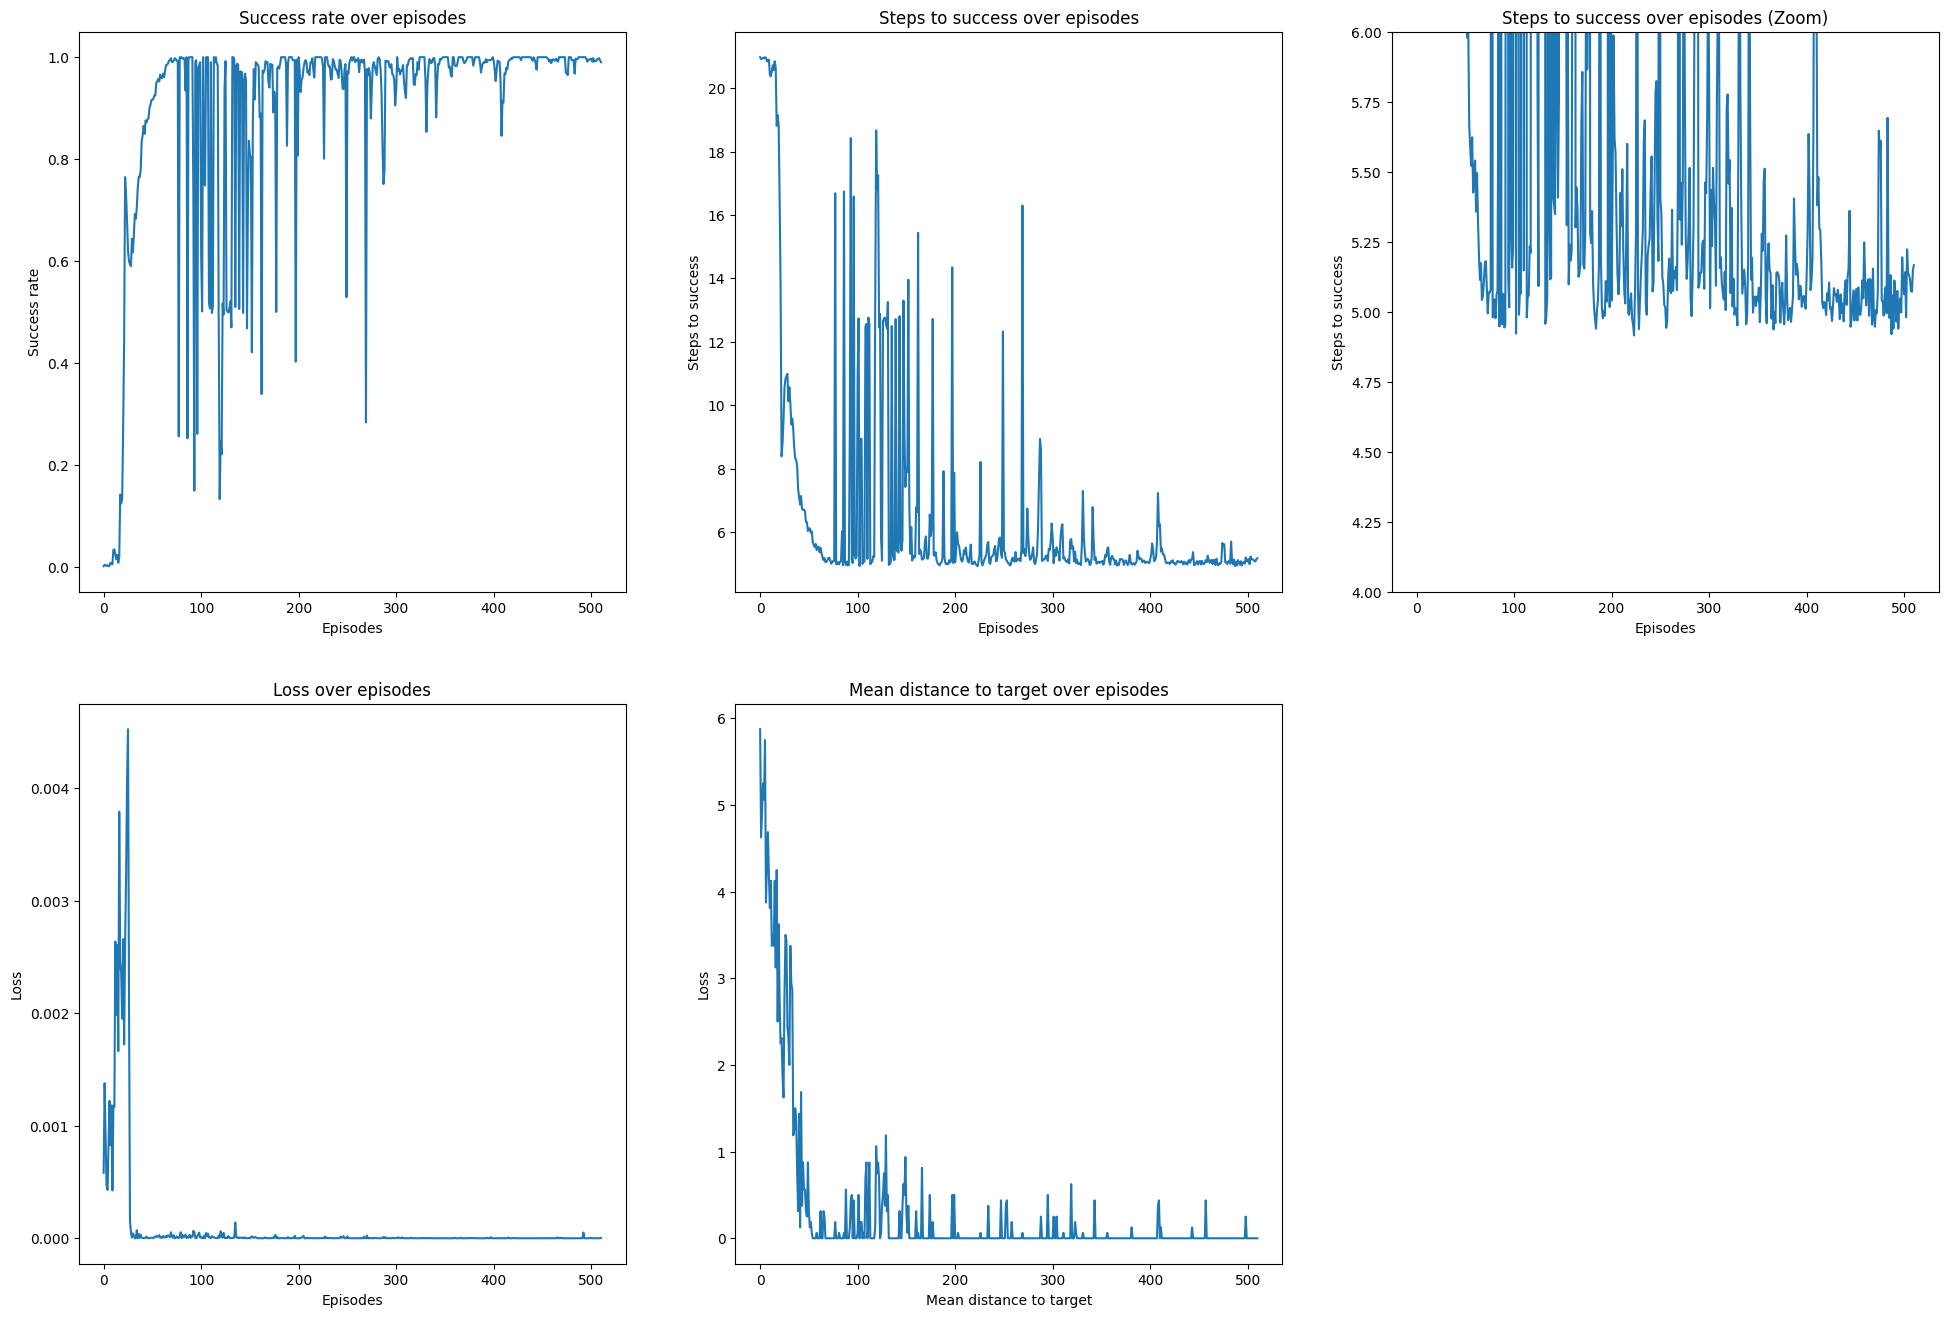

8192


(BitFlippingDQNNetwork(
   (fc1): Linear(in_features=10, out_features=128, bias=True)
   (fc2): Linear(in_features=128, out_features=128, bias=True)
   (fc3): Linear(in_features=128, out_features=10, bias=True)
 ),
 BitFlippingDQNNetwork(
   (fc1): Linear(in_features=10, out_features=128, bias=True)
   (fc2): Linear(in_features=128, out_features=128, bias=True)
   (fc3): Linear(in_features=128, out_features=10, bias=True)
 ))

In [6]:
train_DQN_agent(10, device=device)

$n=15$. Given more training epochs, an optimal agent could be found (avg steps 7.5)

Initialized FlippingBitSequenceEnv with n = 15. Randomly picked target: tensor([1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1], device='cuda:0')
Initial distance to target: 6
-------------------- Initializing DQNAgent --------------------
gamma: 0.95
epsilon: 1.0
epsilon_min: 0.05
epsilon_decay: 0.999
learning_rate: 0.001


  3%|▎         | 101/4000 [00:08<05:19, 12.19it/s]

Episode: 99/4000, Epsilon: 0.05, Success rate: 0.00, Avg steps to success: 31.00, Loss: 0.000000


  5%|▌         | 201/4000 [00:16<04:45, 13.30it/s]

Episode: 199/4000, Epsilon: 0.05, Success rate: 0.00, Avg steps to success: 31.00, Loss: 0.000000


  8%|▊         | 301/4000 [00:24<04:48, 12.81it/s]

Episode: 299/4000, Epsilon: 0.05, Success rate: 0.00, Avg steps to success: 31.00, Loss: 0.000000


 10%|█         | 401/4000 [00:32<05:00, 11.98it/s]

Episode: 399/4000, Epsilon: 0.05, Success rate: 0.00, Avg steps to success: 31.00, Loss: 0.000000


 13%|█▎        | 501/4000 [00:40<04:48, 12.14it/s]

Episode: 499/4000, Epsilon: 0.05, Success rate: 0.00, Avg steps to success: 31.00, Loss: 0.000000


 15%|█▌        | 601/4000 [00:49<04:28, 12.65it/s]

Episode: 599/4000, Epsilon: 0.05, Success rate: 0.00, Avg steps to success: 31.00, Loss: 0.000000


 18%|█▊        | 701/4000 [00:57<04:29, 12.24it/s]

Episode: 699/4000, Epsilon: 0.05, Success rate: 0.00, Avg steps to success: 31.00, Loss: 0.000000


 20%|██        | 801/4000 [01:05<04:22, 12.16it/s]

Episode: 799/4000, Epsilon: 0.05, Success rate: 0.00, Avg steps to success: 31.00, Loss: 0.000000


 23%|██▎       | 901/4000 [01:13<04:20, 11.90it/s]

Episode: 899/4000, Epsilon: 0.05, Success rate: 0.00, Avg steps to success: 30.97, Loss: 0.000000


 25%|██▌       | 1001/4000 [01:22<04:14, 11.80it/s]

Episode: 999/4000, Epsilon: 0.05, Success rate: 0.00, Avg steps to success: 31.00, Loss: 0.000000


 28%|██▊       | 1101/4000 [01:30<03:56, 12.25it/s]

Episode: 1099/4000, Epsilon: 0.05, Success rate: 0.00, Avg steps to success: 31.00, Loss: 0.000000


 30%|███       | 1201/4000 [01:39<03:50, 12.14it/s]

Episode: 1199/4000, Epsilon: 0.05, Success rate: 0.00, Avg steps to success: 31.00, Loss: 0.000000


 33%|███▎      | 1301/4000 [01:47<03:55, 11.44it/s]

Episode: 1299/4000, Epsilon: 0.05, Success rate: 0.00, Avg steps to success: 31.00, Loss: 0.000000


 35%|███▌      | 1401/4000 [01:55<03:27, 12.50it/s]

Episode: 1399/4000, Epsilon: 0.05, Success rate: 0.00, Avg steps to success: 31.00, Loss: 0.000000


 38%|███▊      | 1501/4000 [02:03<03:38, 11.42it/s]

Episode: 1499/4000, Epsilon: 0.05, Success rate: 0.00, Avg steps to success: 31.00, Loss: 0.000000


 40%|████      | 1601/4000 [02:12<03:24, 11.71it/s]

Episode: 1599/4000, Epsilon: 0.05, Success rate: 0.00, Avg steps to success: 31.00, Loss: 0.000000


 43%|████▎     | 1701/4000 [02:20<02:57, 12.95it/s]

Episode: 1699/4000, Epsilon: 0.05, Success rate: 0.00, Avg steps to success: 30.97, Loss: 0.000000


 45%|████▌     | 1801/4000 [02:28<03:01, 12.11it/s]

Episode: 1799/4000, Epsilon: 0.05, Success rate: 0.00, Avg steps to success: 31.00, Loss: 0.000000


 48%|████▊     | 1901/4000 [02:37<02:50, 12.34it/s]

Episode: 1899/4000, Epsilon: 0.05, Success rate: 0.00, Avg steps to success: 31.00, Loss: 0.000000


 50%|█████     | 2001/4000 [02:45<02:41, 12.35it/s]

Episode: 1999/4000, Epsilon: 0.05, Success rate: 0.00, Avg steps to success: 31.00, Loss: 0.000000


 53%|█████▎    | 2101/4000 [02:53<02:30, 12.63it/s]

Episode: 2099/4000, Epsilon: 0.05, Success rate: 0.00, Avg steps to success: 31.00, Loss: 0.000000


 55%|█████▌    | 2201/4000 [03:01<02:21, 12.70it/s]

Episode: 2199/4000, Epsilon: 0.05, Success rate: 0.00, Avg steps to success: 31.00, Loss: 0.000000


 58%|█████▊    | 2301/4000 [03:09<02:19, 12.17it/s]

Episode: 2299/4000, Epsilon: 0.05, Success rate: 0.00, Avg steps to success: 31.00, Loss: 0.000000


 60%|██████    | 2401/4000 [03:18<02:05, 12.73it/s]

Episode: 2399/4000, Epsilon: 0.05, Success rate: 0.00, Avg steps to success: 31.00, Loss: 0.000000


 63%|██████▎   | 2501/4000 [03:26<02:00, 12.43it/s]

Episode: 2499/4000, Epsilon: 0.05, Success rate: 0.00, Avg steps to success: 31.00, Loss: 0.000000


 65%|██████▌   | 2601/4000 [03:34<01:53, 12.35it/s]

Episode: 2599/4000, Epsilon: 0.05, Success rate: 0.00, Avg steps to success: 31.00, Loss: 0.000000


 68%|██████▊   | 2701/4000 [03:42<01:43, 12.52it/s]

Episode: 2699/4000, Epsilon: 0.05, Success rate: 0.00, Avg steps to success: 31.00, Loss: 0.000000


 70%|███████   | 2801/4000 [03:50<01:40, 11.91it/s]

Episode: 2799/4000, Epsilon: 0.05, Success rate: 0.00, Avg steps to success: 31.00, Loss: 0.000000


 73%|███████▎  | 2901/4000 [03:58<01:34, 11.63it/s]

Episode: 2899/4000, Epsilon: 0.05, Success rate: 0.00, Avg steps to success: 31.00, Loss: 0.000000


 75%|███████▌  | 3001/4000 [04:06<01:18, 12.73it/s]

Episode: 2999/4000, Epsilon: 0.05, Success rate: 0.00, Avg steps to success: 31.00, Loss: 0.000000


 78%|███████▊  | 3101/4000 [04:14<01:09, 12.87it/s]

Episode: 3099/4000, Epsilon: 0.05, Success rate: 0.00, Avg steps to success: 31.00, Loss: 0.000000


 80%|████████  | 3201/4000 [04:22<01:02, 12.85it/s]

Episode: 3199/4000, Epsilon: 0.05, Success rate: 0.00, Avg steps to success: 31.00, Loss: 0.000000


 83%|████████▎ | 3301/4000 [04:30<01:00, 11.57it/s]

Episode: 3299/4000, Epsilon: 0.05, Success rate: 0.00, Avg steps to success: 31.00, Loss: 0.000000


 85%|████████▌ | 3401/4000 [04:38<00:46, 12.99it/s]

Episode: 3399/4000, Epsilon: 0.05, Success rate: 0.00, Avg steps to success: 31.00, Loss: 0.000000


 88%|████████▊ | 3501/4000 [04:47<00:40, 12.35it/s]

Episode: 3499/4000, Epsilon: 0.05, Success rate: 0.00, Avg steps to success: 31.00, Loss: 0.000000


 90%|█████████ | 3601/4000 [04:55<00:30, 13.15it/s]

Episode: 3599/4000, Epsilon: 0.05, Success rate: 0.00, Avg steps to success: 31.00, Loss: 0.000000


 93%|█████████▎| 3701/4000 [05:03<00:23, 12.49it/s]

Episode: 3699/4000, Epsilon: 0.05, Success rate: 0.00, Avg steps to success: 31.00, Loss: 0.000000


 95%|█████████▌| 3801/4000 [05:11<00:17, 11.50it/s]

Episode: 3799/4000, Epsilon: 0.05, Success rate: 0.00, Avg steps to success: 31.00, Loss: 0.000000


 98%|█████████▊| 3901/4000 [05:19<00:07, 12.72it/s]

Episode: 3899/4000, Epsilon: 0.05, Success rate: 0.00, Avg steps to success: 31.00, Loss: 0.000000


100%|██████████| 4000/4000 [05:28<00:00, 12.19it/s]


Episode: 3999/4000, Epsilon: 0.05, Success rate: 0.00, Avg steps to success: 30.97, Loss: 0.000000


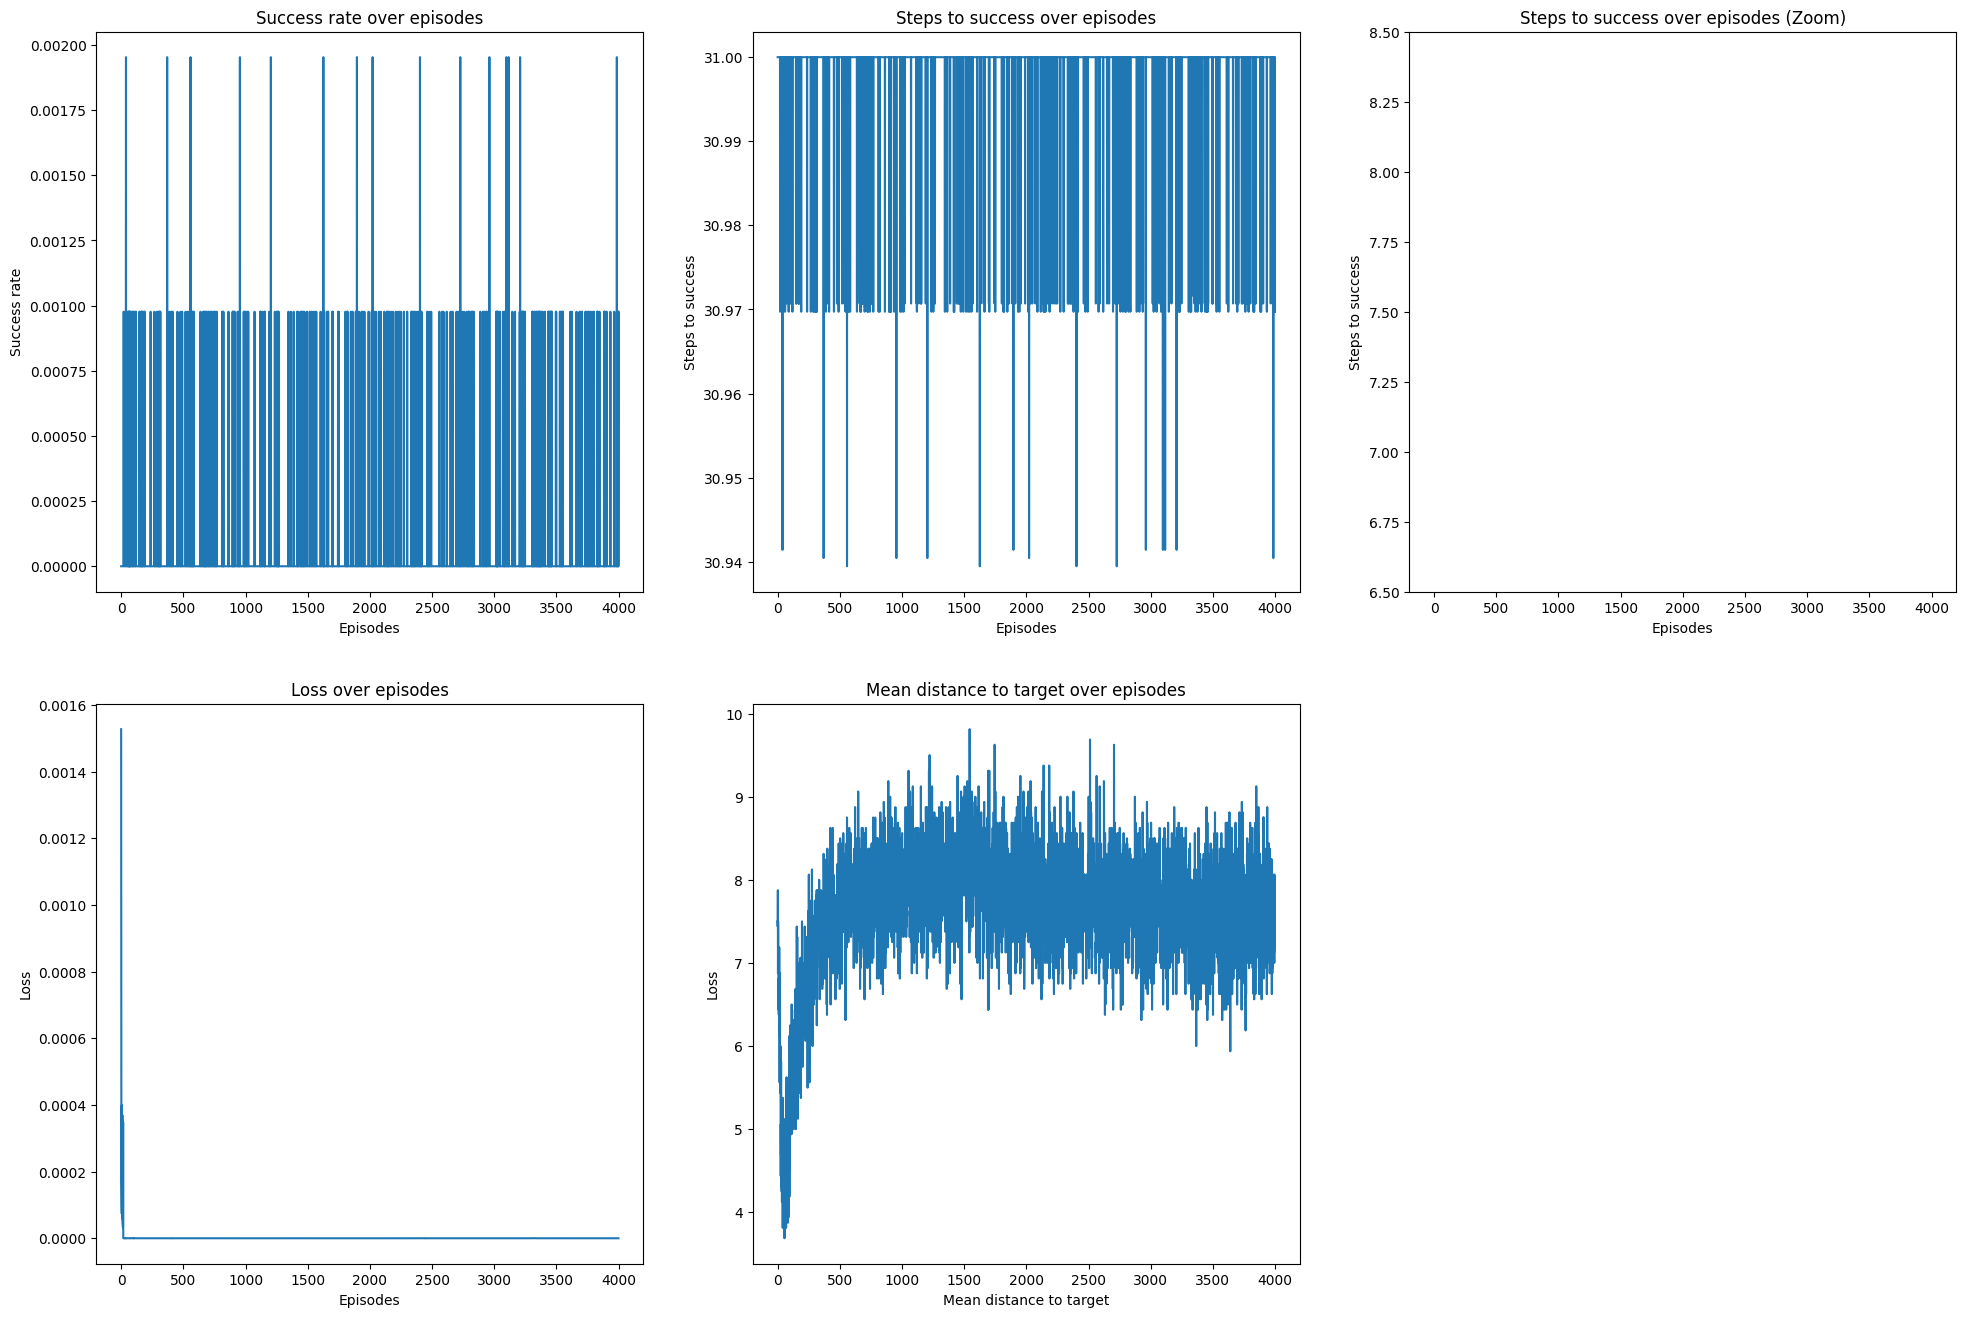

8192


(BitFlippingDQNNetwork(
   (fc1): Linear(in_features=15, out_features=128, bias=True)
   (fc2): Linear(in_features=128, out_features=128, bias=True)
   (fc3): Linear(in_features=128, out_features=15, bias=True)
 ),
 BitFlippingDQNNetwork(
   (fc1): Linear(in_features=15, out_features=128, bias=True)
   (fc2): Linear(in_features=128, out_features=128, bias=True)
   (fc3): Linear(in_features=128, out_features=15, bias=True)
 ))

In [7]:
train_DQN_agent(15, device=device, episodes=4000)

There are 16 agents in each episode, taking 50 steps max. Assuming that a randomly initialized Q-network gives rise to agents that pick actions at random uniformly, we expect that the procedure to visit 800 states. Note that $4000 \times 800 >> 2^{15}$, so it is possible that the state to be reached. In this case, we pick $n=30$, so $\frac{2^{30}}{800}=1342177.28$, and it is probabilistically unlikely that the target state will be visited from random exploration or from the randomly initialized Q-network policy.

$n=30$, as expected, the optimal agent cannot be found. This is due to the reward being too sparse.

Initialized FlippingBitSequenceEnv with n = 30. Randomly picked target: tensor([0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0,
        0, 1, 1, 1, 0, 1], device='cuda:0')
Initial distance to target: 16
-------------------- Initializing DQNAgent --------------------
gamma: 0.95
epsilon: 1.0
epsilon_min: 0.05
epsilon_decay: 0.999
learning_rate: 0.001


  2%|▏         | 101/6000 [00:19<18:43,  5.25it/s]

Episode: 99/6000, Epsilon: 0.05, Success rate: 0.00, Avg steps to success: 61.00, Loss: 0.000000


  3%|▎         | 201/6000 [00:38<19:13,  5.03it/s]

Episode: 199/6000, Epsilon: 0.05, Success rate: 0.00, Avg steps to success: 61.00, Loss: 0.000000


  5%|▌         | 300/6000 [00:57<18:50,  5.04it/s]

Episode: 299/6000, Epsilon: 0.05, Success rate: 0.00, Avg steps to success: 61.00, Loss: 0.000000


  7%|▋         | 401/6000 [01:17<18:14,  5.11it/s]

Episode: 399/6000, Epsilon: 0.05, Success rate: 0.00, Avg steps to success: 61.00, Loss: 0.000000


  8%|▊         | 501/6000 [01:36<17:56,  5.11it/s]

Episode: 499/6000, Epsilon: 0.05, Success rate: 0.00, Avg steps to success: 61.00, Loss: 0.000000


 10%|█         | 601/6000 [01:56<16:17,  5.52it/s]

Episode: 599/6000, Epsilon: 0.05, Success rate: 0.00, Avg steps to success: 61.00, Loss: 0.000000


 12%|█▏        | 701/6000 [02:14<16:03,  5.50it/s]

Episode: 699/6000, Epsilon: 0.05, Success rate: 0.00, Avg steps to success: 61.00, Loss: 0.000000


 13%|█▎        | 801/6000 [02:33<15:43,  5.51it/s]

Episode: 799/6000, Epsilon: 0.05, Success rate: 0.00, Avg steps to success: 61.00, Loss: 0.000000


 15%|█▌        | 901/6000 [02:52<16:50,  5.04it/s]

Episode: 899/6000, Epsilon: 0.05, Success rate: 0.00, Avg steps to success: 61.00, Loss: 0.000000


 17%|█▋        | 1000/6000 [03:12<16:30,  5.05it/s]

Episode: 999/6000, Epsilon: 0.05, Success rate: 0.00, Avg steps to success: 61.00, Loss: 0.000000


 18%|█▊        | 1101/6000 [03:31<15:27,  5.28it/s]

Episode: 1099/6000, Epsilon: 0.05, Success rate: 0.00, Avg steps to success: 61.00, Loss: 0.000000


 20%|██        | 1201/6000 [03:51<16:03,  4.98it/s]

Episode: 1199/6000, Epsilon: 0.05, Success rate: 0.00, Avg steps to success: 61.00, Loss: 0.000000


 22%|██▏       | 1301/6000 [04:09<13:58,  5.61it/s]

Episode: 1299/6000, Epsilon: 0.05, Success rate: 0.00, Avg steps to success: 61.00, Loss: 0.000000


 23%|██▎       | 1401/6000 [04:28<15:12,  5.04it/s]

Episode: 1399/6000, Epsilon: 0.05, Success rate: 0.00, Avg steps to success: 61.00, Loss: 0.000000


 25%|██▌       | 1501/6000 [04:46<13:20,  5.62it/s]

Episode: 1499/6000, Epsilon: 0.05, Success rate: 0.00, Avg steps to success: 61.00, Loss: 0.000000


 27%|██▋       | 1601/6000 [05:05<14:12,  5.16it/s]

Episode: 1599/6000, Epsilon: 0.05, Success rate: 0.00, Avg steps to success: 61.00, Loss: 0.000000


 28%|██▊       | 1701/6000 [05:24<12:17,  5.83it/s]

Episode: 1699/6000, Epsilon: 0.05, Success rate: 0.00, Avg steps to success: 61.00, Loss: 0.000000


 30%|███       | 1801/6000 [05:43<13:55,  5.02it/s]

Episode: 1799/6000, Epsilon: 0.05, Success rate: 0.00, Avg steps to success: 61.00, Loss: 0.000000


 32%|███▏      | 1901/6000 [06:02<13:32,  5.05it/s]

Episode: 1899/6000, Epsilon: 0.05, Success rate: 0.00, Avg steps to success: 61.00, Loss: 0.000000


 33%|███▎      | 2001/6000 [06:20<11:57,  5.57it/s]

Episode: 1999/6000, Epsilon: 0.05, Success rate: 0.00, Avg steps to success: 61.00, Loss: 0.000000


 35%|███▌      | 2101/6000 [06:40<12:41,  5.12it/s]

Episode: 2099/6000, Epsilon: 0.05, Success rate: 0.00, Avg steps to success: 61.00, Loss: 0.000000


 37%|███▋      | 2200/6000 [06:59<12:38,  5.01it/s]

Episode: 2199/6000, Epsilon: 0.05, Success rate: 0.00, Avg steps to success: 61.00, Loss: 0.000000


 38%|███▊      | 2300/6000 [07:18<11:51,  5.20it/s]

Episode: 2299/6000, Epsilon: 0.05, Success rate: 0.00, Avg steps to success: 61.00, Loss: 0.000000


 40%|████      | 2401/6000 [07:37<11:53,  5.05it/s]

Episode: 2399/6000, Epsilon: 0.05, Success rate: 0.00, Avg steps to success: 61.00, Loss: 0.000000


 42%|████▏     | 2501/6000 [07:56<10:18,  5.65it/s]

Episode: 2499/6000, Epsilon: 0.05, Success rate: 0.00, Avg steps to success: 61.00, Loss: 0.000000


 43%|████▎     | 2601/6000 [08:16<11:18,  5.01it/s]

Episode: 2599/6000, Epsilon: 0.05, Success rate: 0.00, Avg steps to success: 61.00, Loss: 0.000000


 45%|████▌     | 2701/6000 [08:36<11:01,  4.99it/s]

Episode: 2699/6000, Epsilon: 0.05, Success rate: 0.00, Avg steps to success: 61.00, Loss: 0.000000


 47%|████▋     | 2800/6000 [08:55<11:02,  4.83it/s]

Episode: 2799/6000, Epsilon: 0.05, Success rate: 0.00, Avg steps to success: 61.00, Loss: 0.000000


 48%|████▊     | 2901/6000 [09:15<10:16,  5.02it/s]

Episode: 2899/6000, Epsilon: 0.05, Success rate: 0.00, Avg steps to success: 61.00, Loss: 0.000000


 50%|█████     | 3001/6000 [09:33<08:52,  5.63it/s]

Episode: 2999/6000, Epsilon: 0.05, Success rate: 0.00, Avg steps to success: 61.00, Loss: 0.000000


 52%|█████▏    | 3101/6000 [09:52<09:23,  5.15it/s]

Episode: 3099/6000, Epsilon: 0.05, Success rate: 0.00, Avg steps to success: 61.00, Loss: 0.000000


 53%|█████▎    | 3201/6000 [10:12<09:00,  5.18it/s]

Episode: 3199/6000, Epsilon: 0.05, Success rate: 0.00, Avg steps to success: 61.00, Loss: 0.000000


 55%|█████▌    | 3300/6000 [10:31<09:14,  4.87it/s]

Episode: 3299/6000, Epsilon: 0.05, Success rate: 0.00, Avg steps to success: 61.00, Loss: 0.000000


 57%|█████▋    | 3401/6000 [10:51<08:35,  5.04it/s]

Episode: 3399/6000, Epsilon: 0.05, Success rate: 0.00, Avg steps to success: 61.00, Loss: 0.000000


 58%|█████▊    | 3501/6000 [11:10<08:16,  5.04it/s]

Episode: 3499/6000, Epsilon: 0.05, Success rate: 0.00, Avg steps to success: 61.00, Loss: 0.000000


 60%|██████    | 3601/6000 [11:28<07:01,  5.69it/s]

Episode: 3599/6000, Epsilon: 0.05, Success rate: 0.00, Avg steps to success: 61.00, Loss: 0.000000


 62%|██████▏   | 3701/6000 [11:47<07:14,  5.29it/s]

Episode: 3699/6000, Epsilon: 0.05, Success rate: 0.00, Avg steps to success: 61.00, Loss: 0.000000


 63%|██████▎   | 3801/6000 [12:05<07:09,  5.12it/s]

Episode: 3799/6000, Epsilon: 0.05, Success rate: 0.00, Avg steps to success: 61.00, Loss: 0.000000


 65%|██████▌   | 3901/6000 [12:24<06:37,  5.28it/s]

Episode: 3899/6000, Epsilon: 0.05, Success rate: 0.00, Avg steps to success: 61.00, Loss: 0.000000


 67%|██████▋   | 4001/6000 [12:43<06:28,  5.14it/s]

Episode: 3999/6000, Epsilon: 0.05, Success rate: 0.00, Avg steps to success: 61.00, Loss: 0.000000


 68%|██████▊   | 4100/6000 [13:03<07:07,  4.45it/s]

Episode: 4099/6000, Epsilon: 0.05, Success rate: 0.00, Avg steps to success: 61.00, Loss: 0.000000


 70%|███████   | 4200/6000 [13:21<05:54,  5.07it/s]

Episode: 4199/6000, Epsilon: 0.05, Success rate: 0.00, Avg steps to success: 61.00, Loss: 0.000000


 72%|███████▏  | 4301/6000 [13:41<05:28,  5.17it/s]

Episode: 4299/6000, Epsilon: 0.05, Success rate: 0.00, Avg steps to success: 61.00, Loss: 0.000000


 73%|███████▎  | 4401/6000 [14:01<05:10,  5.15it/s]

Episode: 4399/6000, Epsilon: 0.05, Success rate: 0.00, Avg steps to success: 61.00, Loss: 0.000000


 75%|███████▌  | 4501/6000 [14:20<04:56,  5.05it/s]

Episode: 4499/6000, Epsilon: 0.05, Success rate: 0.00, Avg steps to success: 61.00, Loss: 0.000000


 77%|███████▋  | 4601/6000 [14:39<04:37,  5.04it/s]

Episode: 4599/6000, Epsilon: 0.05, Success rate: 0.00, Avg steps to success: 61.00, Loss: 0.000000


 78%|███████▊  | 4700/6000 [14:58<04:22,  4.95it/s]

Episode: 4699/6000, Epsilon: 0.05, Success rate: 0.00, Avg steps to success: 61.00, Loss: 0.000000


 80%|████████  | 4801/6000 [15:18<04:12,  4.75it/s]

Episode: 4799/6000, Epsilon: 0.05, Success rate: 0.00, Avg steps to success: 61.00, Loss: 0.000000


 82%|████████▏ | 4901/6000 [15:36<03:39,  5.00it/s]

Episode: 4899/6000, Epsilon: 0.05, Success rate: 0.00, Avg steps to success: 61.00, Loss: 0.000000


 83%|████████▎ | 5001/6000 [15:56<03:09,  5.28it/s]

Episode: 4999/6000, Epsilon: 0.05, Success rate: 0.00, Avg steps to success: 61.00, Loss: 0.000000


 85%|████████▌ | 5101/6000 [16:15<02:59,  5.02it/s]

Episode: 5099/6000, Epsilon: 0.05, Success rate: 0.00, Avg steps to success: 61.00, Loss: 0.000000


 87%|████████▋ | 5201/6000 [16:35<02:38,  5.04it/s]

Episode: 5199/6000, Epsilon: 0.05, Success rate: 0.00, Avg steps to success: 61.00, Loss: 0.000000


 88%|████████▊ | 5301/6000 [16:55<02:18,  5.06it/s]

Episode: 5299/6000, Epsilon: 0.05, Success rate: 0.00, Avg steps to success: 61.00, Loss: 0.000000


 90%|█████████ | 5401/6000 [17:15<01:58,  5.06it/s]

Episode: 5399/6000, Epsilon: 0.05, Success rate: 0.00, Avg steps to success: 61.00, Loss: 0.000000


 92%|█████████▏| 5501/6000 [17:34<01:27,  5.72it/s]

Episode: 5499/6000, Epsilon: 0.05, Success rate: 0.00, Avg steps to success: 61.00, Loss: 0.000000


 93%|█████████▎| 5601/6000 [17:52<01:12,  5.50it/s]

Episode: 5599/6000, Epsilon: 0.05, Success rate: 0.00, Avg steps to success: 61.00, Loss: 0.000000


 95%|█████████▌| 5701/6000 [18:11<00:58,  5.12it/s]

Episode: 5699/6000, Epsilon: 0.05, Success rate: 0.00, Avg steps to success: 61.00, Loss: 0.000000


 97%|█████████▋| 5801/6000 [18:30<00:38,  5.17it/s]

Episode: 5799/6000, Epsilon: 0.05, Success rate: 0.00, Avg steps to success: 61.00, Loss: 0.000000


 98%|█████████▊| 5901/6000 [18:49<00:17,  5.78it/s]

Episode: 5899/6000, Epsilon: 0.05, Success rate: 0.00, Avg steps to success: 61.00, Loss: 0.000000


100%|██████████| 6000/6000 [19:07<00:00,  5.23it/s]


Episode: 5999/6000, Epsilon: 0.05, Success rate: 0.00, Avg steps to success: 61.00, Loss: 0.000000


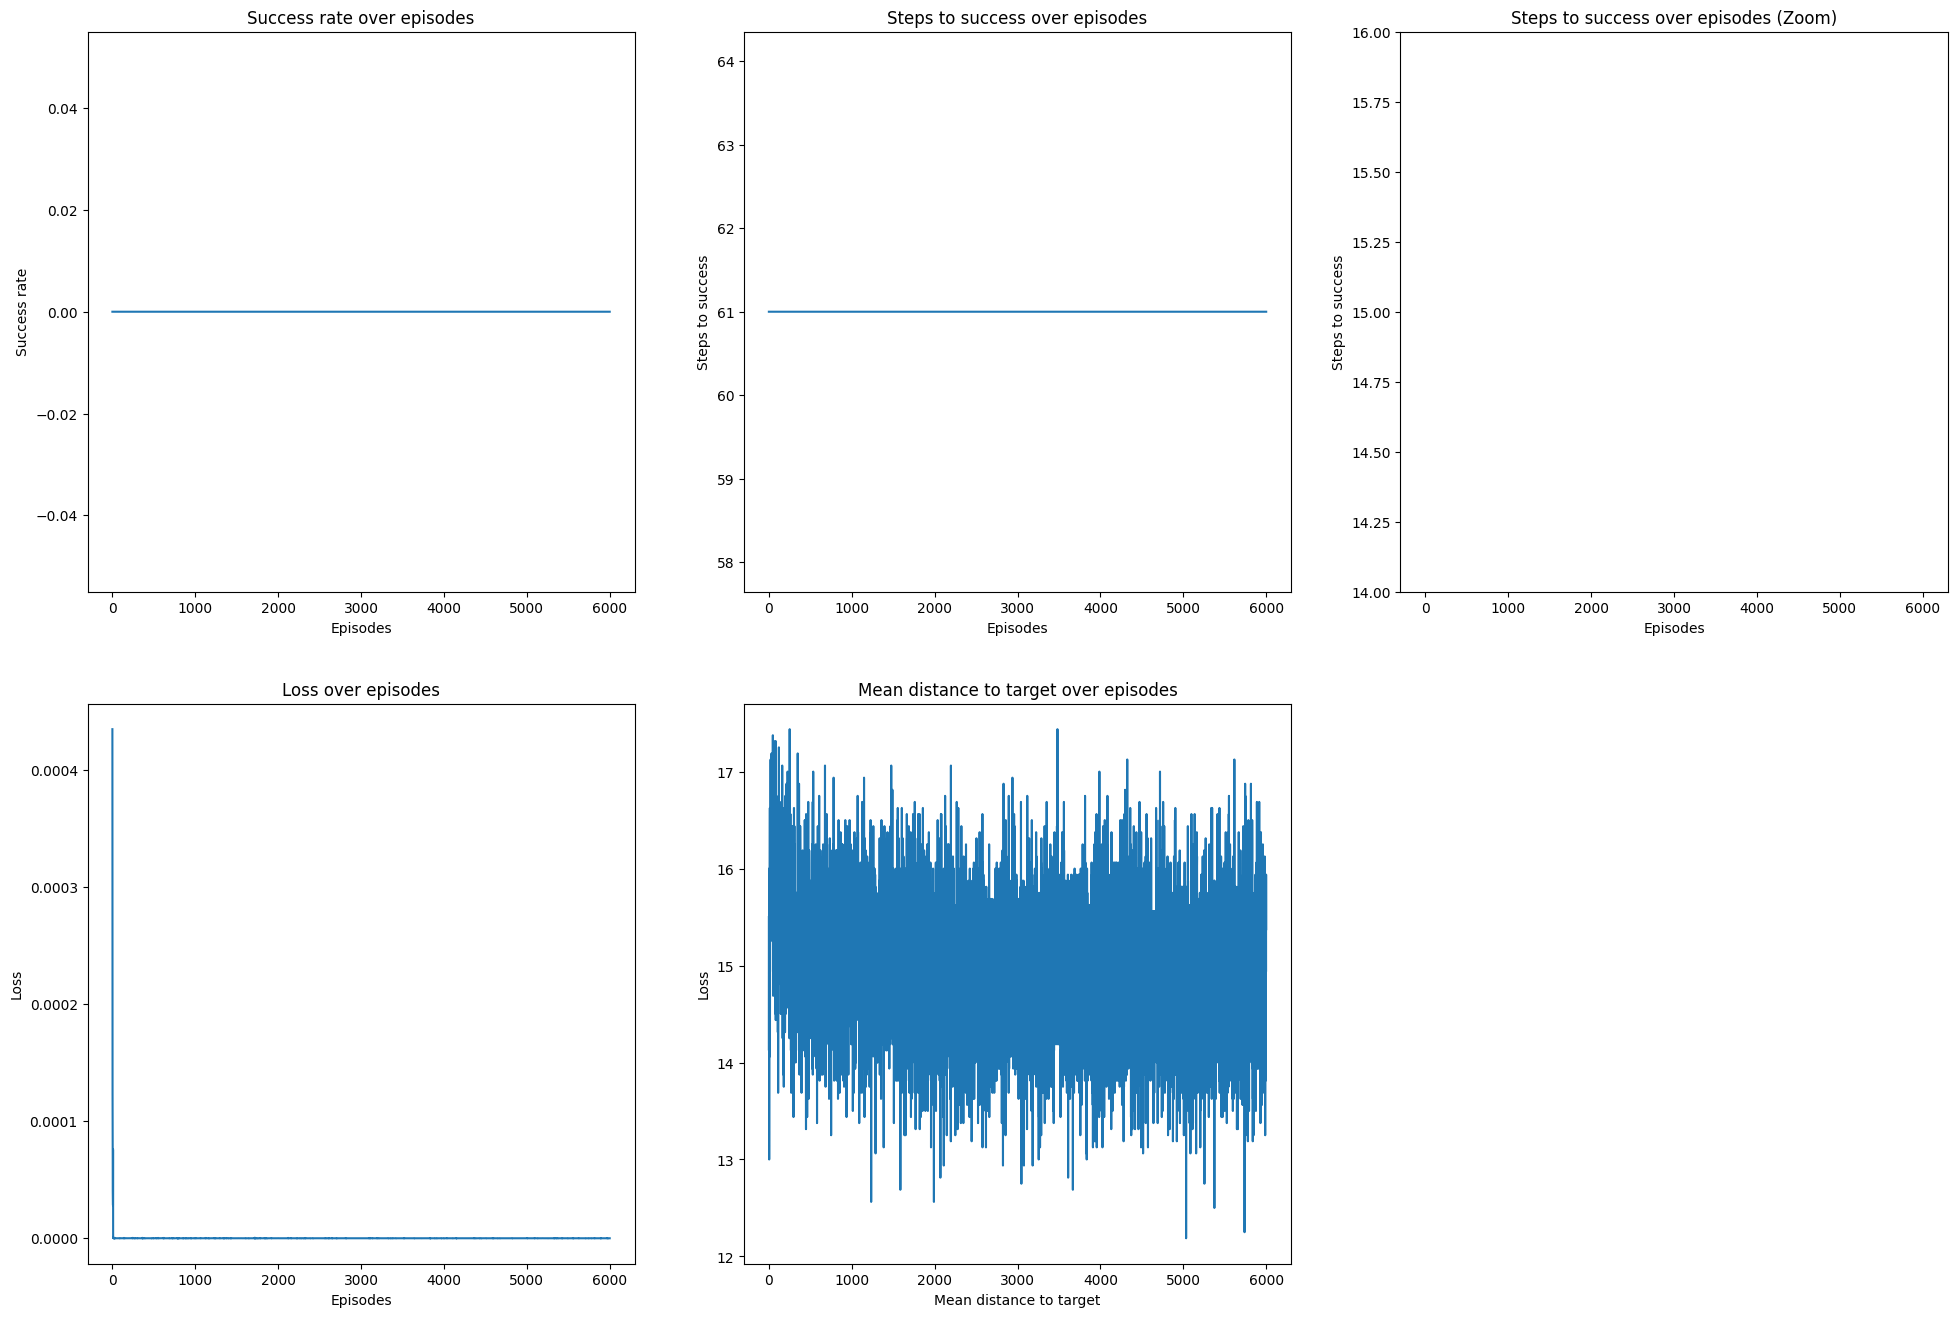

8192


(BitFlippingDQNNetwork(
   (fc1): Linear(in_features=30, out_features=128, bias=True)
   (fc2): Linear(in_features=128, out_features=128, bias=True)
   (fc3): Linear(in_features=128, out_features=30, bias=True)
 ),
 BitFlippingDQNNetwork(
   (fc1): Linear(in_features=30, out_features=128, bias=True)
   (fc2): Linear(in_features=128, out_features=128, bias=True)
   (fc3): Linear(in_features=128, out_features=30, bias=True)
 ))

In [8]:
train_DQN_agent(30, device=device, episodes=6000)